### <span style="font-family: Arial; font-weight:bold;font-size:1.4em;color:#D68910"> MRA Milestone 2 Project - Grocery Store Data - Market Basket Analysis

#### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#424949"> A Grocery Store shared the transactional data with you. Your job is to identify the most popular combos that can be suggested to the Grocery Store chain after a thorough analysis of the most commonly occurring sets of items in the customer orders. 
    
#### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#424949"> The Store doesn’t have any combo offers. Can you suggest the best combos & offers?

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore                                        # ZSCORE SCALING
from sklearn.preprocessing import StandardScaler                 # ZScore

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, centroid          # HIERARCHICAL CLUSTERING 
from sklearn.cluster import KMeans                                    # K-MEANS CLUSTERING

from sklearn.metrics import silhouette_samples, silhouette_score      # SILHOUETTE SCORE FOR K-MEANS

from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(color_codes=True)
sns.set_palette('Accent_r')

%config InlineBackend.figure_format ='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize'] = 16, 9

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Load and Explore Dataset

In [37]:
df = pd.read_csv('dataset_group.csv')
df.head(10).to_csv('df_head.csv')
df.head(10)

,Date,Order_id,Product
0,01-01-2018,1,yogurt
1,01-01-2018,1,pork
2,01-01-2018,1,sandwich bags
3,01-01-2018,1,lunch meat
4,01-01-2018,1,all- purpose
5,01-01-2018,1,flour
6,01-01-2018,1,soda
7,01-01-2018,1,butter
8,01-01-2018,1,beef
9,01-01-2018,1,aluminum foil


In [38]:
df.shape

(20641, 3)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641 entries, 0 to 20640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      20641 non-null  object
 1   Order_id  20641 non-null  int64 
 2   Product   20641 non-null  object
dtypes: int64(1), object(2)
memory usage: 483.9+ KB


In [40]:
df.describe().T.to_csv('describe_num.csv');
df.describe(include='object').T.to_csv('describe_cat.csv');

df.describe(include='object').T
df.describe().T

,count,unique,top,freq
Date,20641,603,08-02-2019,183
Product,20641,37,poultry,640


,count,mean,std,min,25%,50%,75%,max
Order_id,20641.0,575.986289,328.557078,1.0,292.0,581.0,862.0,1139.0


In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20641 entries, 0 to 20640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      20641 non-null  datetime64[ns]
 1   Order_id  20641 non-null  int64         
 2   Product   20641 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 483.9+ KB


In [36]:
df.describe().T.to_csv('describe_num.csv');
df.describe(include='object').T.to_csv('describe_cat.csv');

df.describe(include='object').T
df.describe().T

,count,unique,top,freq
Product,20641,37,poultry,640


,count,mean,std,min,25%,50%,75%,max
Order_id,20641.0,575.986289,328.557078,1.0,292.0,581.0,862.0,1139.0


In [7]:
df_datesplit = df.copy()

In [8]:
df_datesplit['YEAR'] = pd.PeriodIndex(df_datesplit['Date'], freq='Y')
df_datesplit['MONTH'] = pd.PeriodIndex(df_datesplit['Date'], freq='M')
df_datesplit['QUARTER'] = pd.PeriodIndex(df_datesplit['Date'], freq='Q')
df_datesplit['WEEK'] = pd.PeriodIndex(df_datesplit['Date'], freq='W')


In [9]:
df_datesplit['DAY'] = df_datesplit.Date.dt.strftime('%A')
df_datesplit['MONTH_NAME'] = df_datesplit['Date'].dt.strftime('%b')

In [10]:
df_datesplit.head()

df_datesplit.tail()

,Date,Order_id,Product,YEAR,MONTH,QUARTER,WEEK,DAY,MONTH_NAME
0,2018-01-01,1,yogurt,2018,2018-01,2018Q1,2018-01-01/2018-01-07,Monday,Jan
1,2018-01-01,1,pork,2018,2018-01,2018Q1,2018-01-01/2018-01-07,Monday,Jan
2,2018-01-01,1,sandwich bags,2018,2018-01,2018Q1,2018-01-01/2018-01-07,Monday,Jan
3,2018-01-01,1,lunch meat,2018,2018-01,2018Q1,2018-01-01/2018-01-07,Monday,Jan
4,2018-01-01,1,all- purpose,2018,2018-01,2018Q1,2018-01-01/2018-01-07,Monday,Jan


,Date,Order_id,Product,YEAR,MONTH,QUARTER,WEEK,DAY,MONTH_NAME
20636,2020-02-25,1138,soda,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Tuesday,Feb
20637,2020-02-25,1138,paper towels,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Tuesday,Feb
20638,2020-02-26,1139,soda,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Wednesday,Feb
20639,2020-02-26,1139,laundry detergent,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Wednesday,Feb
20640,2020-02-26,1139,shampoo,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Wednesday,Feb


In [11]:
df_datesplit.tail(50)

,Date,Order_id,Product,YEAR,MONTH,QUARTER,WEEK,DAY,MONTH_NAME
20591,2020-02-23,1136,dinner rolls,2020,2020-02,2020Q1,2020-02-17/2020-02-23,Sunday,Feb
20592,2020-02-23,1136,individual meals,2020,2020-02,2020Q1,2020-02-17/2020-02-23,Sunday,Feb
20593,2020-02-23,1136,hand soap,2020,2020-02,2020Q1,2020-02-17/2020-02-23,Sunday,Feb
20594,2020-02-23,1136,milk,2020,2020-02,2020Q1,2020-02-17/2020-02-23,Sunday,Feb
20595,2020-02-23,1136,dinner rolls,2020,2020-02,2020Q1,2020-02-17/2020-02-23,Sunday,Feb
20596,2020-02-24,1137,beef,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Monday,Feb
20597,2020-02-24,1137,lunch meat,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Monday,Feb
20598,2020-02-24,1137,eggs,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Monday,Feb
20599,2020-02-24,1137,poultry,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Monday,Feb
20600,2020-02-24,1137,tortillas,2020,2020-02,2020Q1,2020-02-24/2020-03-01,Monday,Feb


In [12]:
print('First date of Sales data = ', min(df_datesplit['Date']))
print('Last date of Sales data = ', max(df_datesplit['Date']))

First date of Sales data =  2018-01-01 00:00:00
Last date of Sales data =  2020-02-26 00:00:00


### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - YEARLY

In [13]:
df3 = df_datesplit.copy()
df_yr = pd.DataFrame(df3[['YEAR', 'Order_id', 'Product']].groupby('YEAR').agg({'Order_id': 'nunique',
                                                                  'Product': 'count'}))
newname = {'Order_id': 'Num_of_Orders', 'Product': 'Num_of_Products'}
df_yr.rename(columns=newname, inplace=True)
df_yr

,Num_of_Orders,Num_of_Products
YEAR,,
2018,533,9479
2019,507,9333
2020,99,1829


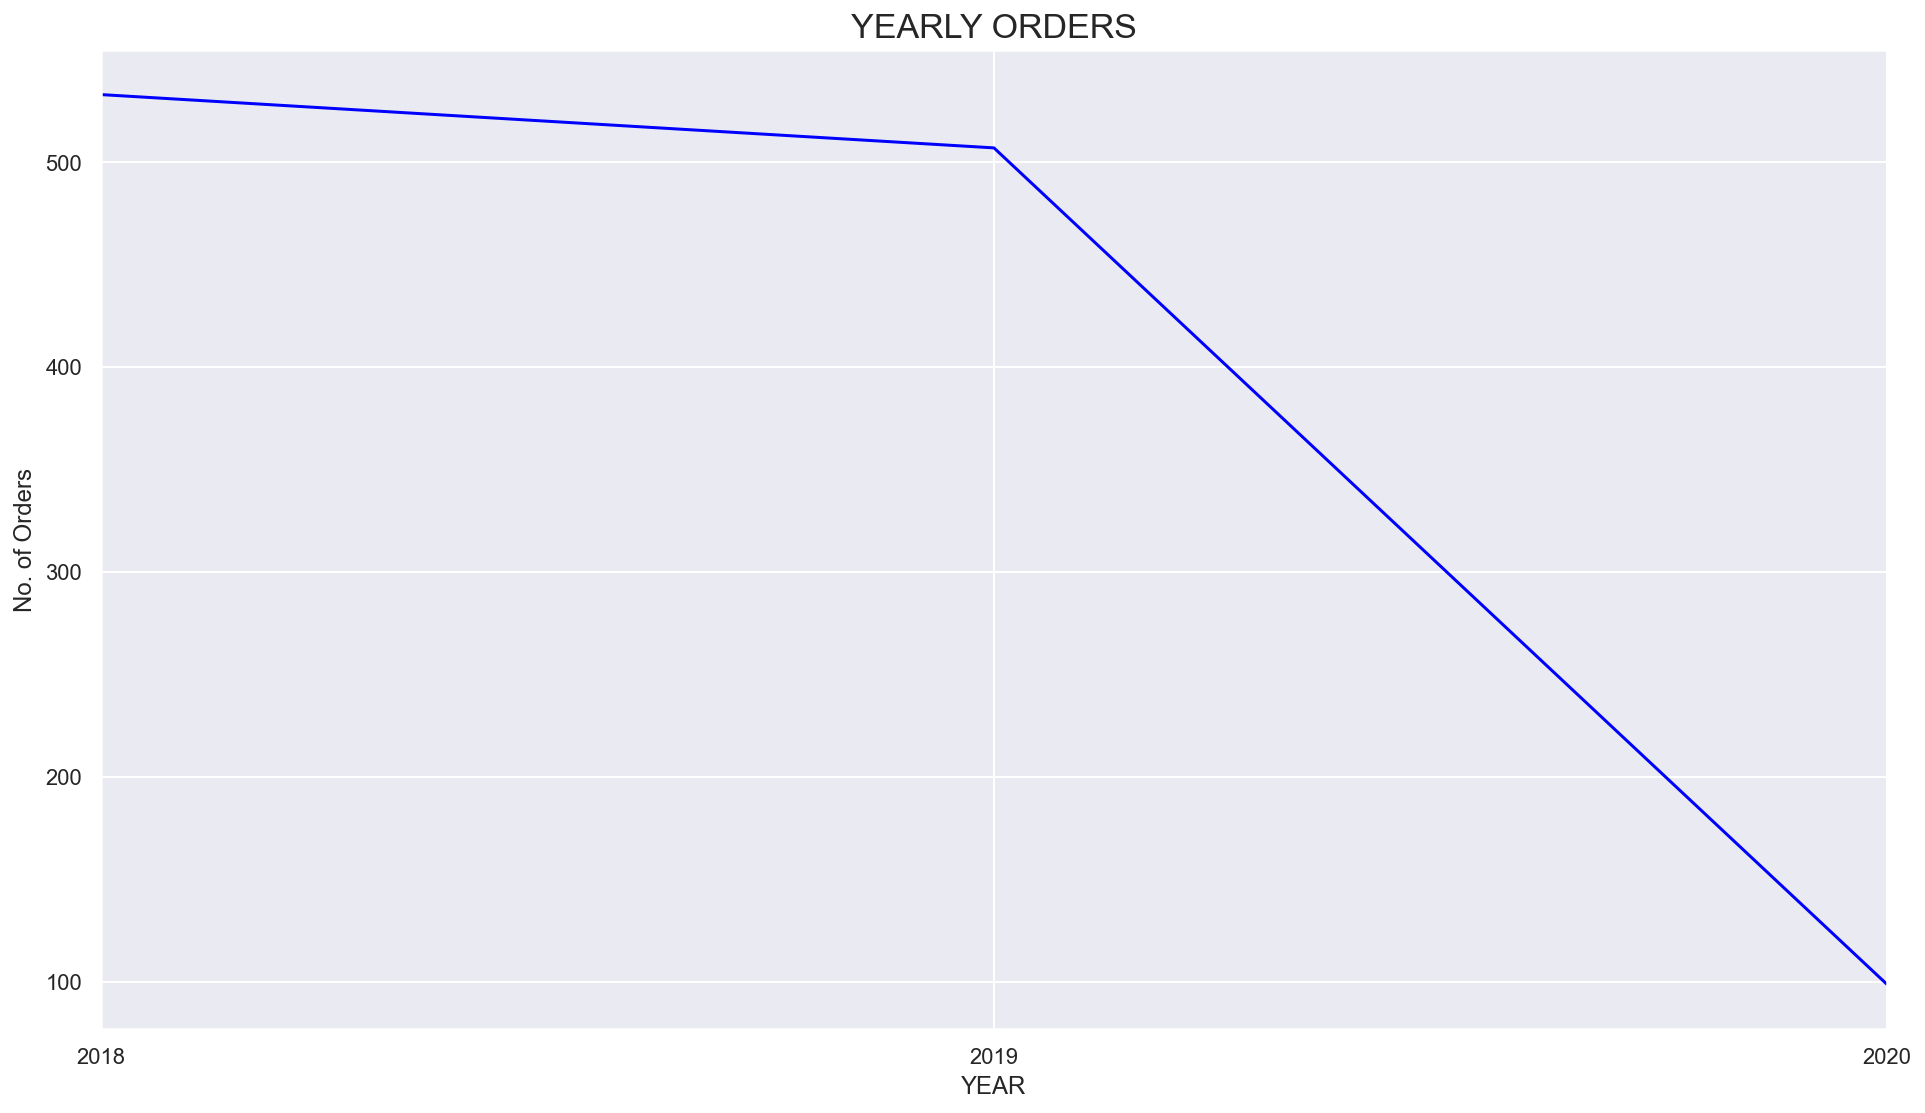

In [52]:
df_yr['Num_of_Orders'].plot(color='blue');
plt.ylabel('No. of Orders');
plt.title('YEARLY ORDERS', fontsize=17)
plt.savefig('ts_YEAR_order.jpg', bbox_inches='tight');

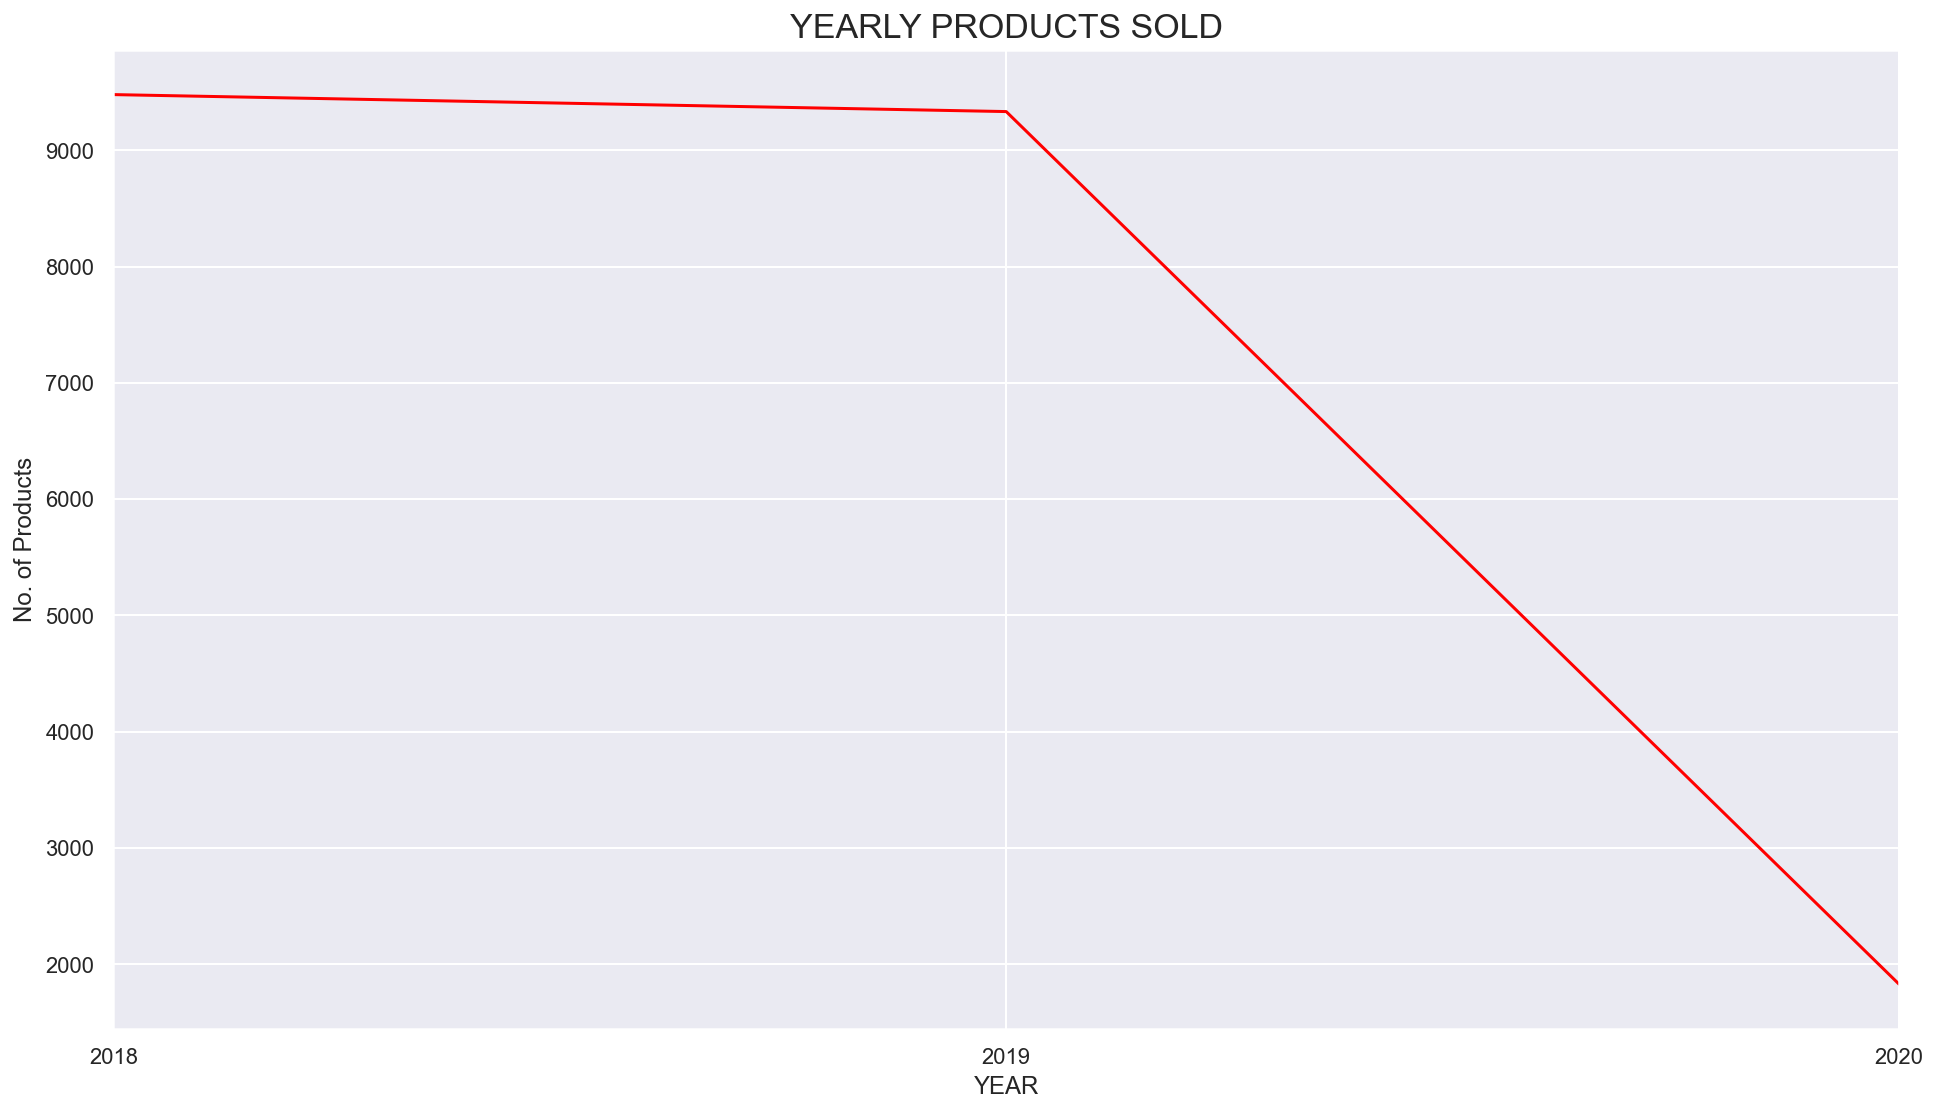

In [53]:
df_yr['Num_of_Products'].plot(color='red');
plt.ylabel('No. of Products');
plt.title('YEARLY PRODUCTS SOLD', fontsize=17)
plt.savefig('ts_YEAR_prod.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - QUARTERLY

In [16]:
df3 = df_datesplit.copy()
df_qtr = pd.DataFrame(df3[['QUARTER', 'Order_id', 'Product']].groupby('QUARTER').agg({'Order_id': 'nunique',
                                                                  'Product': 'count'}))
newname = {'Order_id': 'Num_of_Orders', 'Product': 'Num_of_Products'}
df_qtr.rename(columns=newname, inplace=True)
df_qtr

,Num_of_Orders,Num_of_Products
QUARTER,,
2018Q1,175,3114
2018Q2,178,3047
2018Q3,180,3318
2019Q1,180,3354
2019Q2,170,3054
2019Q3,157,2925
2020Q1,99,1829


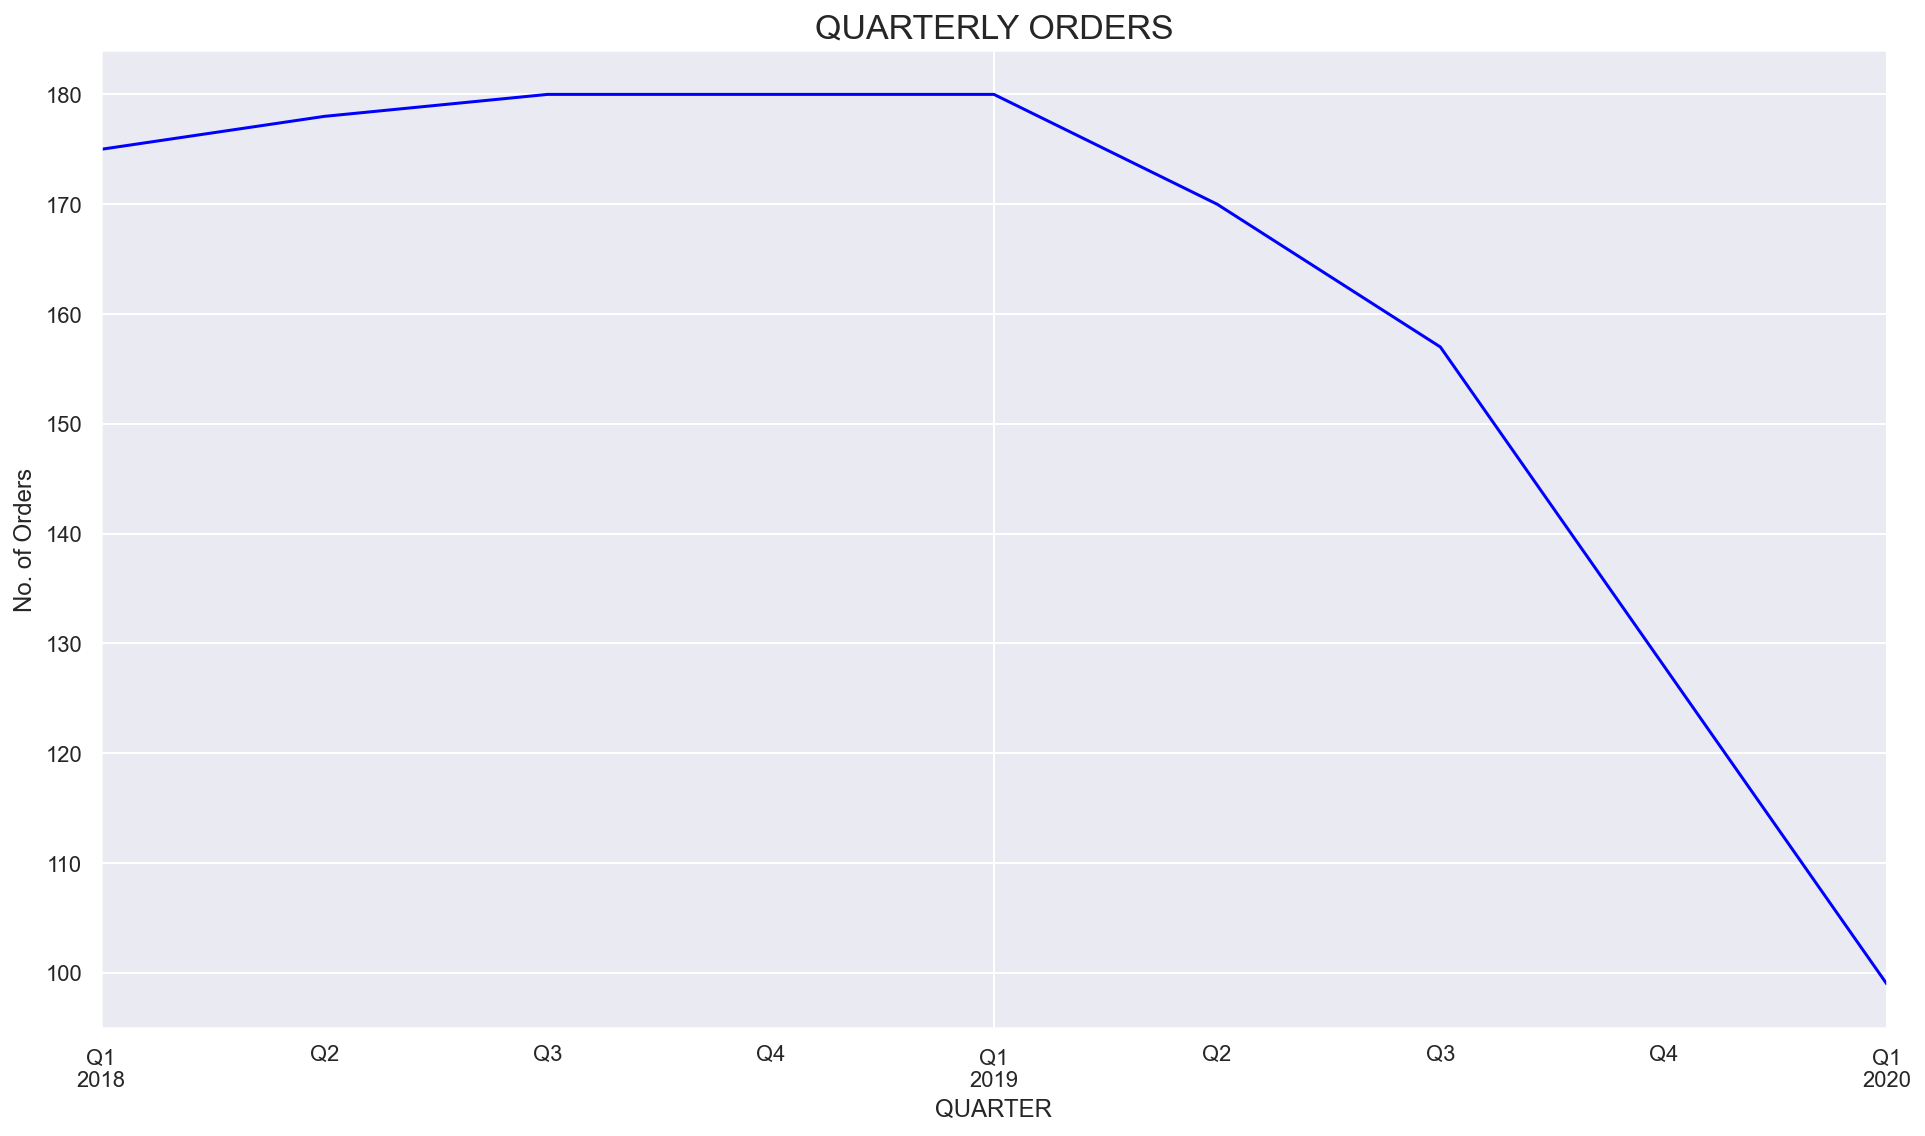

In [55]:
df_qtr['Num_of_Orders'].plot(color='blue');
plt.ylabel('No. of Orders');
plt.title('QUARTERLY ORDERS', fontsize=17)
plt.savefig('ts_qtr_order.jpg', bbox_inches='tight');

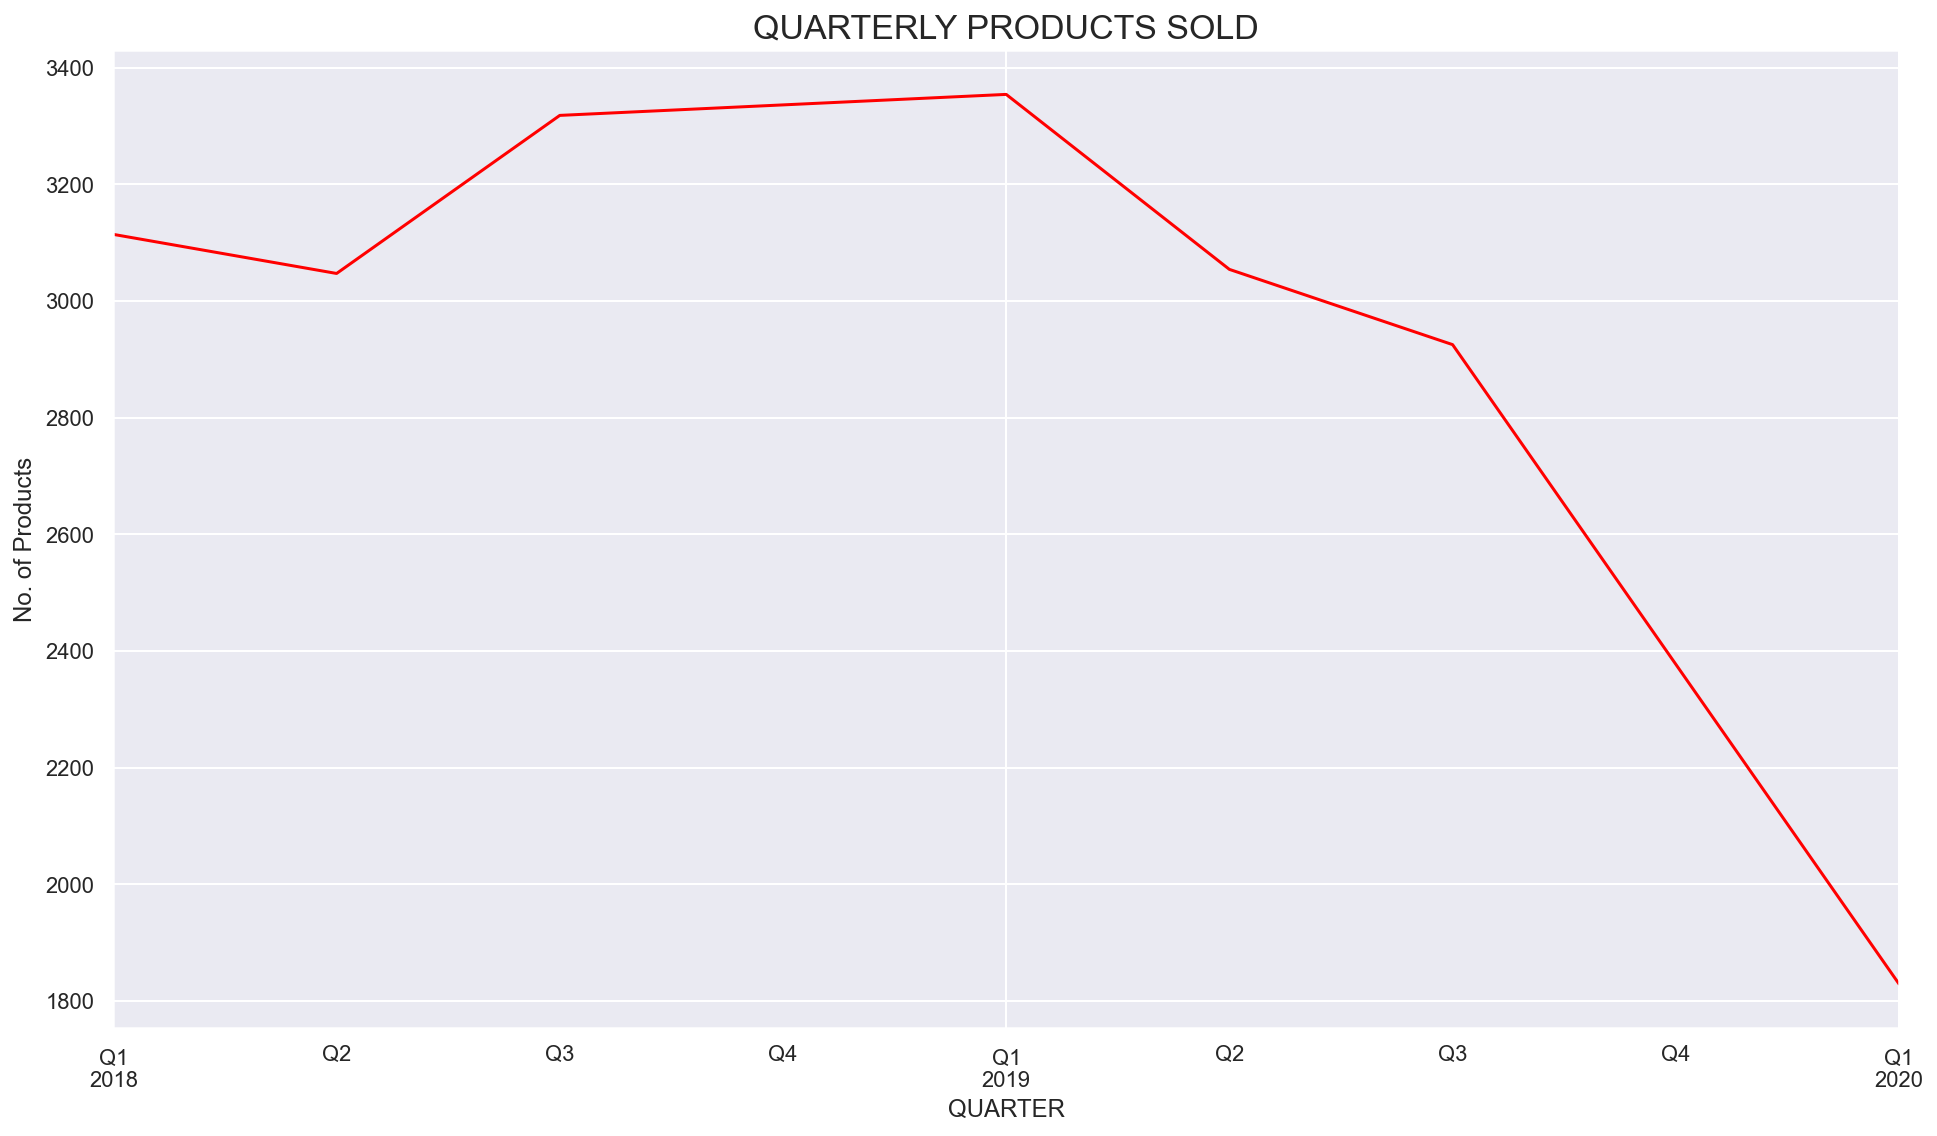

In [56]:
df_qtr['Num_of_Products'].plot(color='red');
plt.ylabel('No. of Products');
plt.title('QUARTERLY PRODUCTS SOLD', fontsize=17)
plt.savefig('ts_qtr_prod.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - MONTHLY

In [19]:
df3 = df_datesplit.copy()
df_month = pd.DataFrame(df3[['MONTH', 'Order_id', 'Product']].groupby('MONTH').agg({'Order_id': 'nunique',
                                                                  'Product': 'count'}))
newname = {'Order_id': 'Num_of_Orders', 'Product': 'Num_of_Products'}
df_month.rename(columns=newname, inplace=True)
df_month

,Num_of_Orders,Num_of_Products
MONTH,,
2018-01,62,1170
2018-02,55,907
2018-03,58,1037
2018-04,55,962
2018-05,67,1155
2018-06,56,930
2018-07,62,1054
2018-08,59,1159
2018-09,59,1105


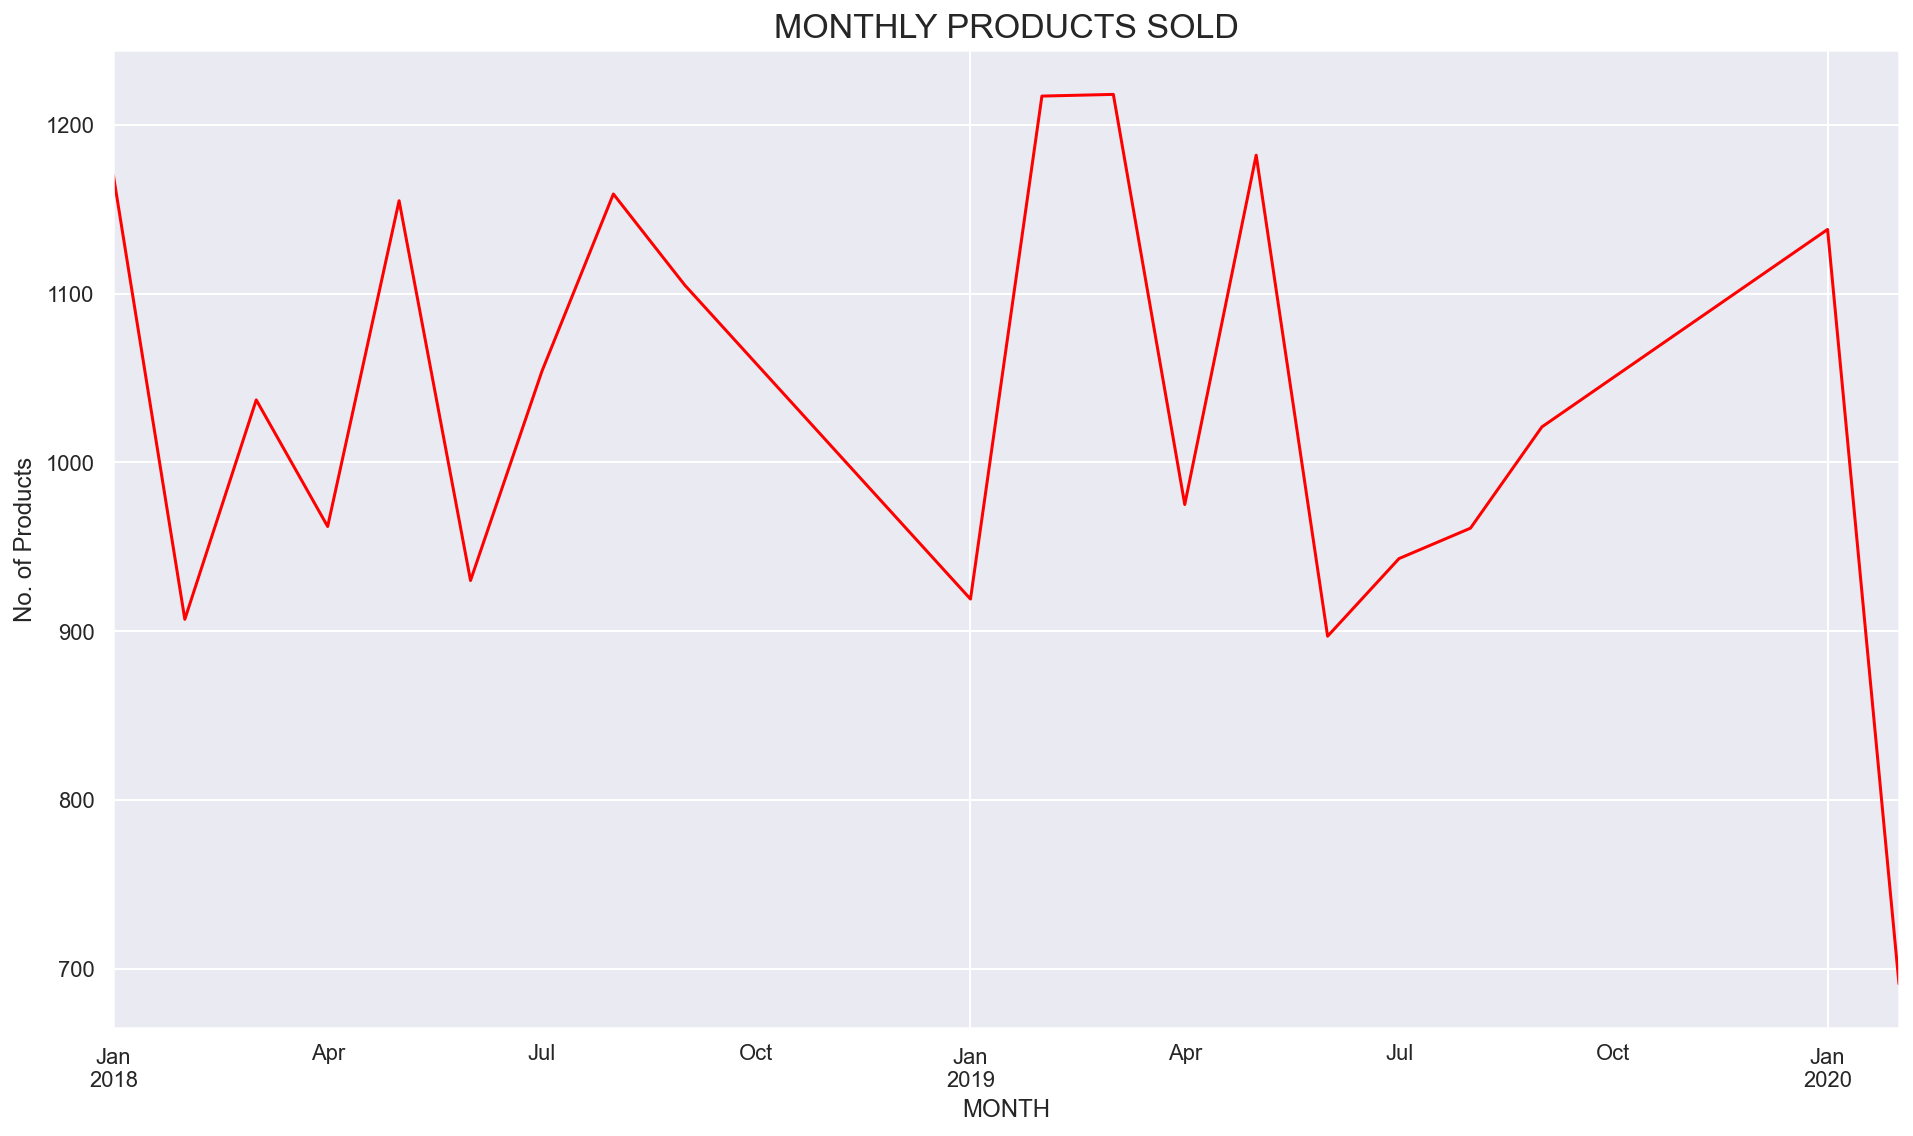

In [57]:
df_month['Num_of_Products'].plot(color='red');
plt.ylabel('No. of Products');
plt.title('MONTHLY PRODUCTS SOLD', fontsize=17)
plt.savefig('ts_month_prod.jpg', bbox_inches='tight');

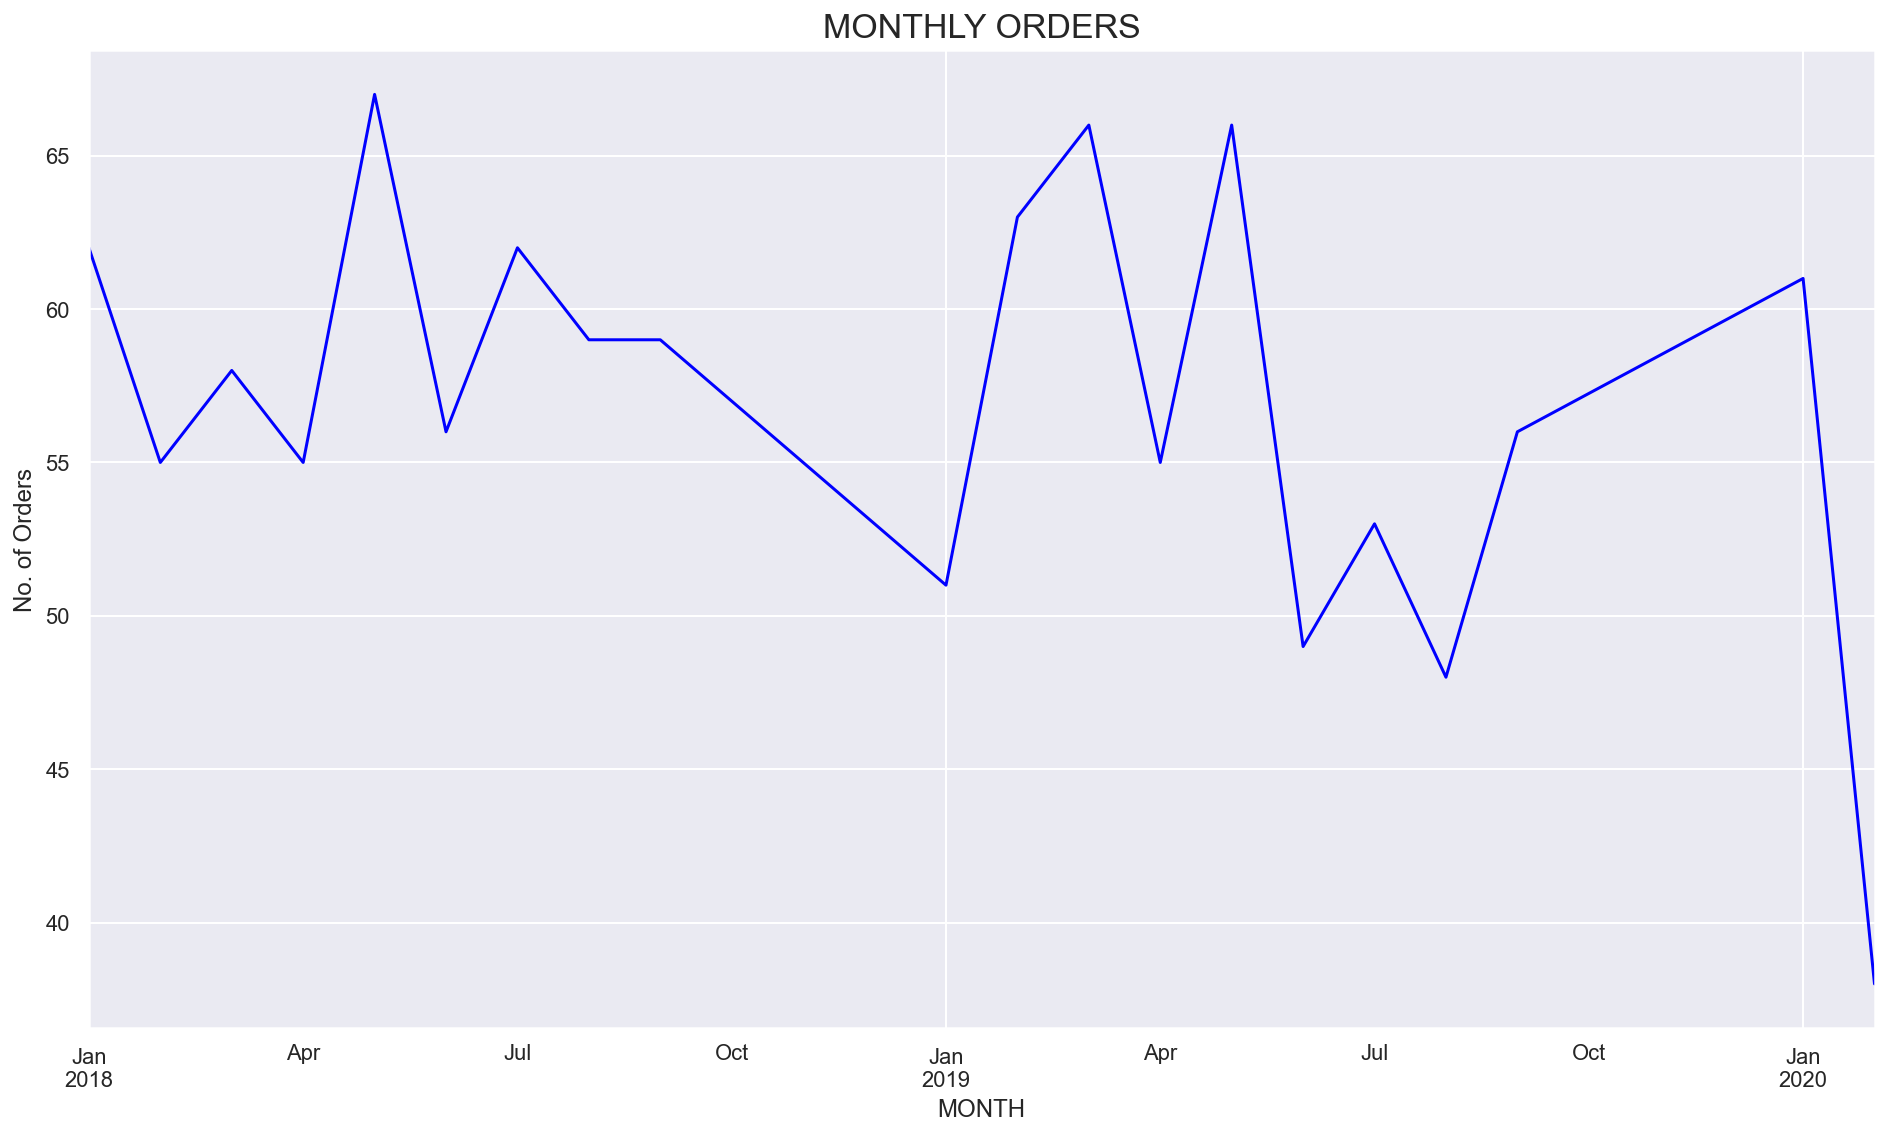

In [58]:
df_month['Num_of_Orders'].plot(color='blue');
plt.ylabel('No. of Orders');
plt.title('MONTHLY ORDERS', fontsize=17)
plt.savefig('ts_month_orders.jpg', bbox_inches='tight');

### <span style="font-family: Arial; font-weight:bold;font-size:1.2em;color:#0e92ea"> Time Series - WEEKLY

In [22]:
df3 = df_datesplit.copy()
df_week = pd.DataFrame(df3[['WEEK', 'Order_id', 'Product']].groupby('WEEK').agg({'Order_id': 'nunique',
                                                                  'Product': 'count'}))
newname = {'Order_id': 'Num_of_Orders', 'Product': 'Num_of_Products'}
df_week.rename(columns=newname, inplace=True)
df_week

,Num_of_Orders,Num_of_Products
WEEK,,
2018-01-01/2018-01-07,15,285
2018-01-08/2018-01-14,15,247
2018-01-15/2018-01-21,17,350
2018-01-22/2018-01-28,8,151
2018-01-29/2018-02-04,17,304
...,...,...
2020-01-27/2020-02-02,10,204
2020-02-03/2020-02-09,13,202
2020-02-10/2020-02-16,10,183


In [23]:
df_week['Num_of_Orders'].mean()
df_week['Num_of_Orders'].median()

12.943181818181818

13.0

In [24]:
df_week['Num_of_Products'].mean()
df_week['Num_of_Products'].median()

234.5568181818182

232.0

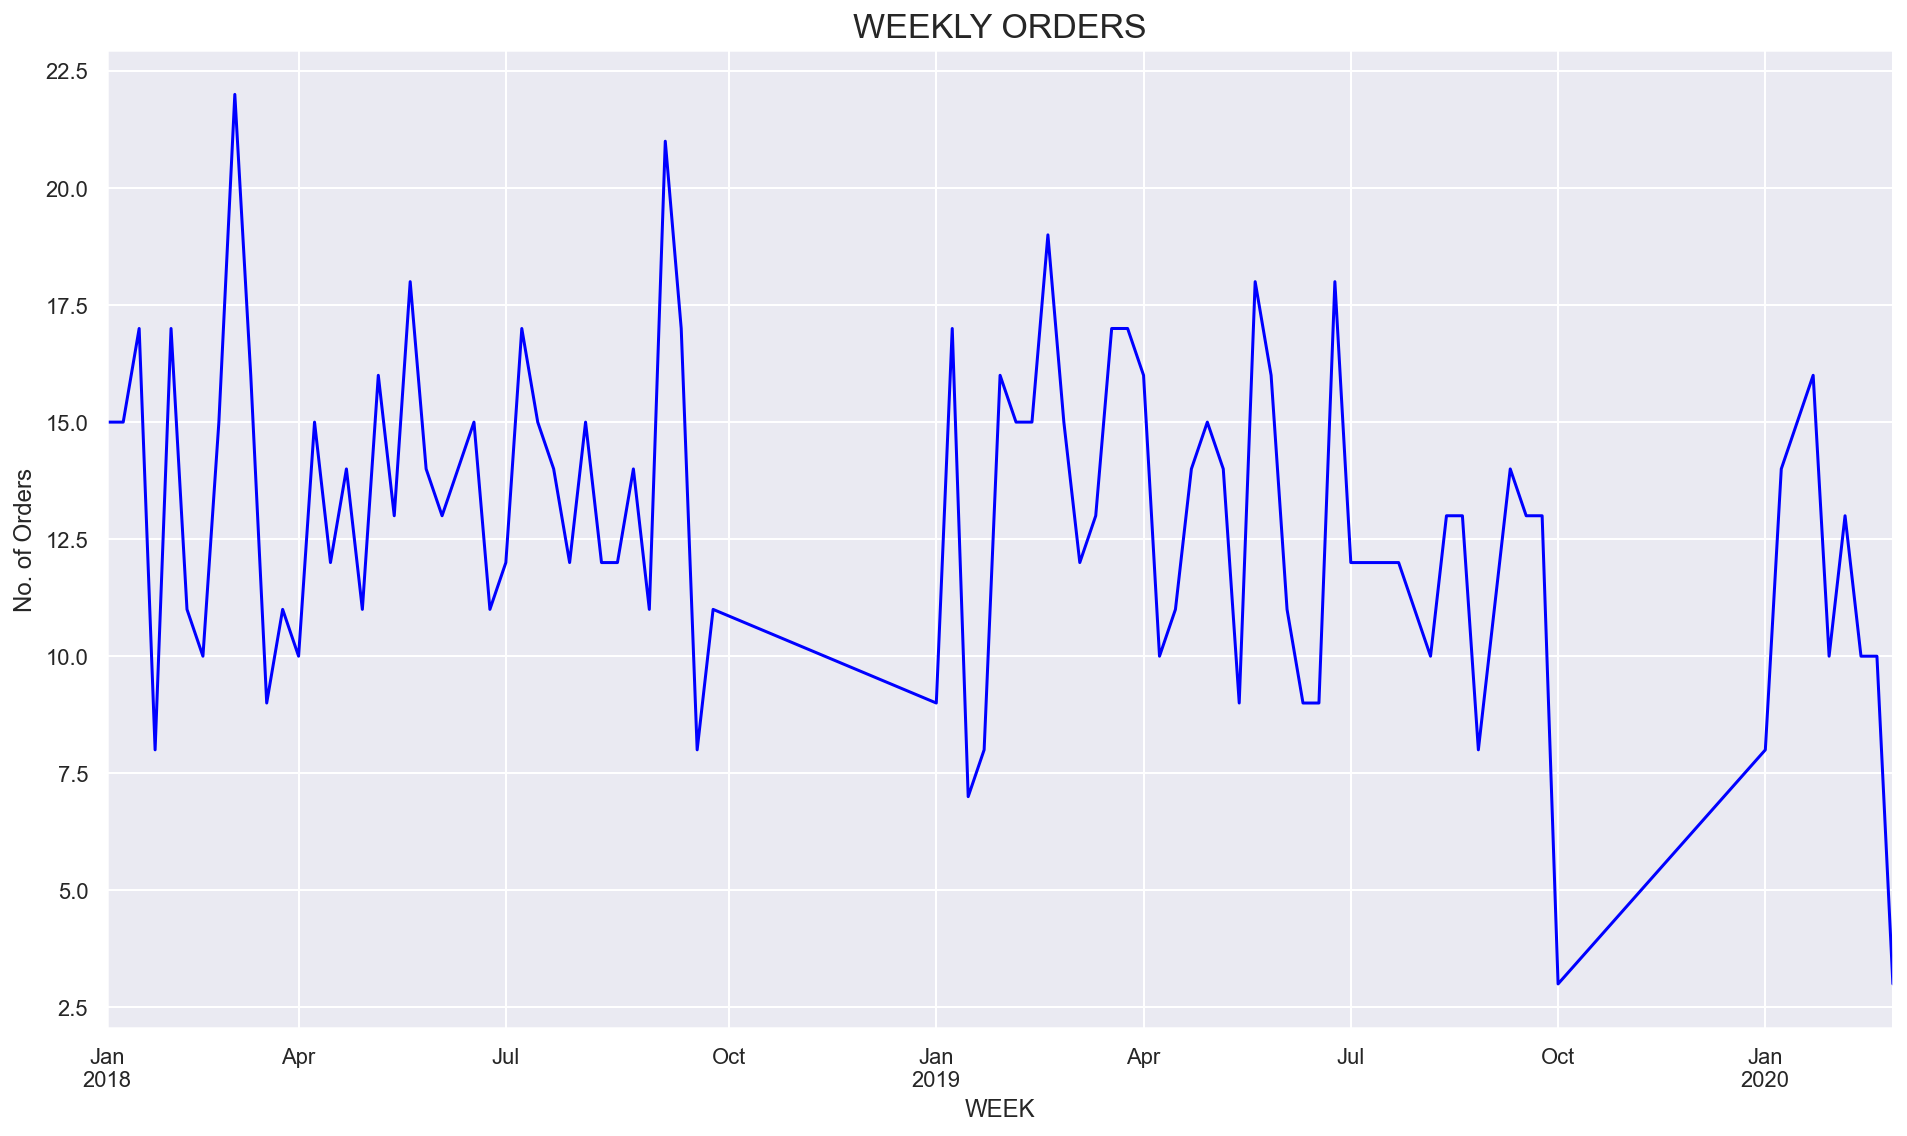

In [59]:
df_week['Num_of_Orders'].plot(color='blue');
plt.ylabel('No. of Orders');
plt.title('WEEKLY ORDERS', fontsize=17)
plt.savefig('ts_week_orders.jpg', bbox_inches='tight');

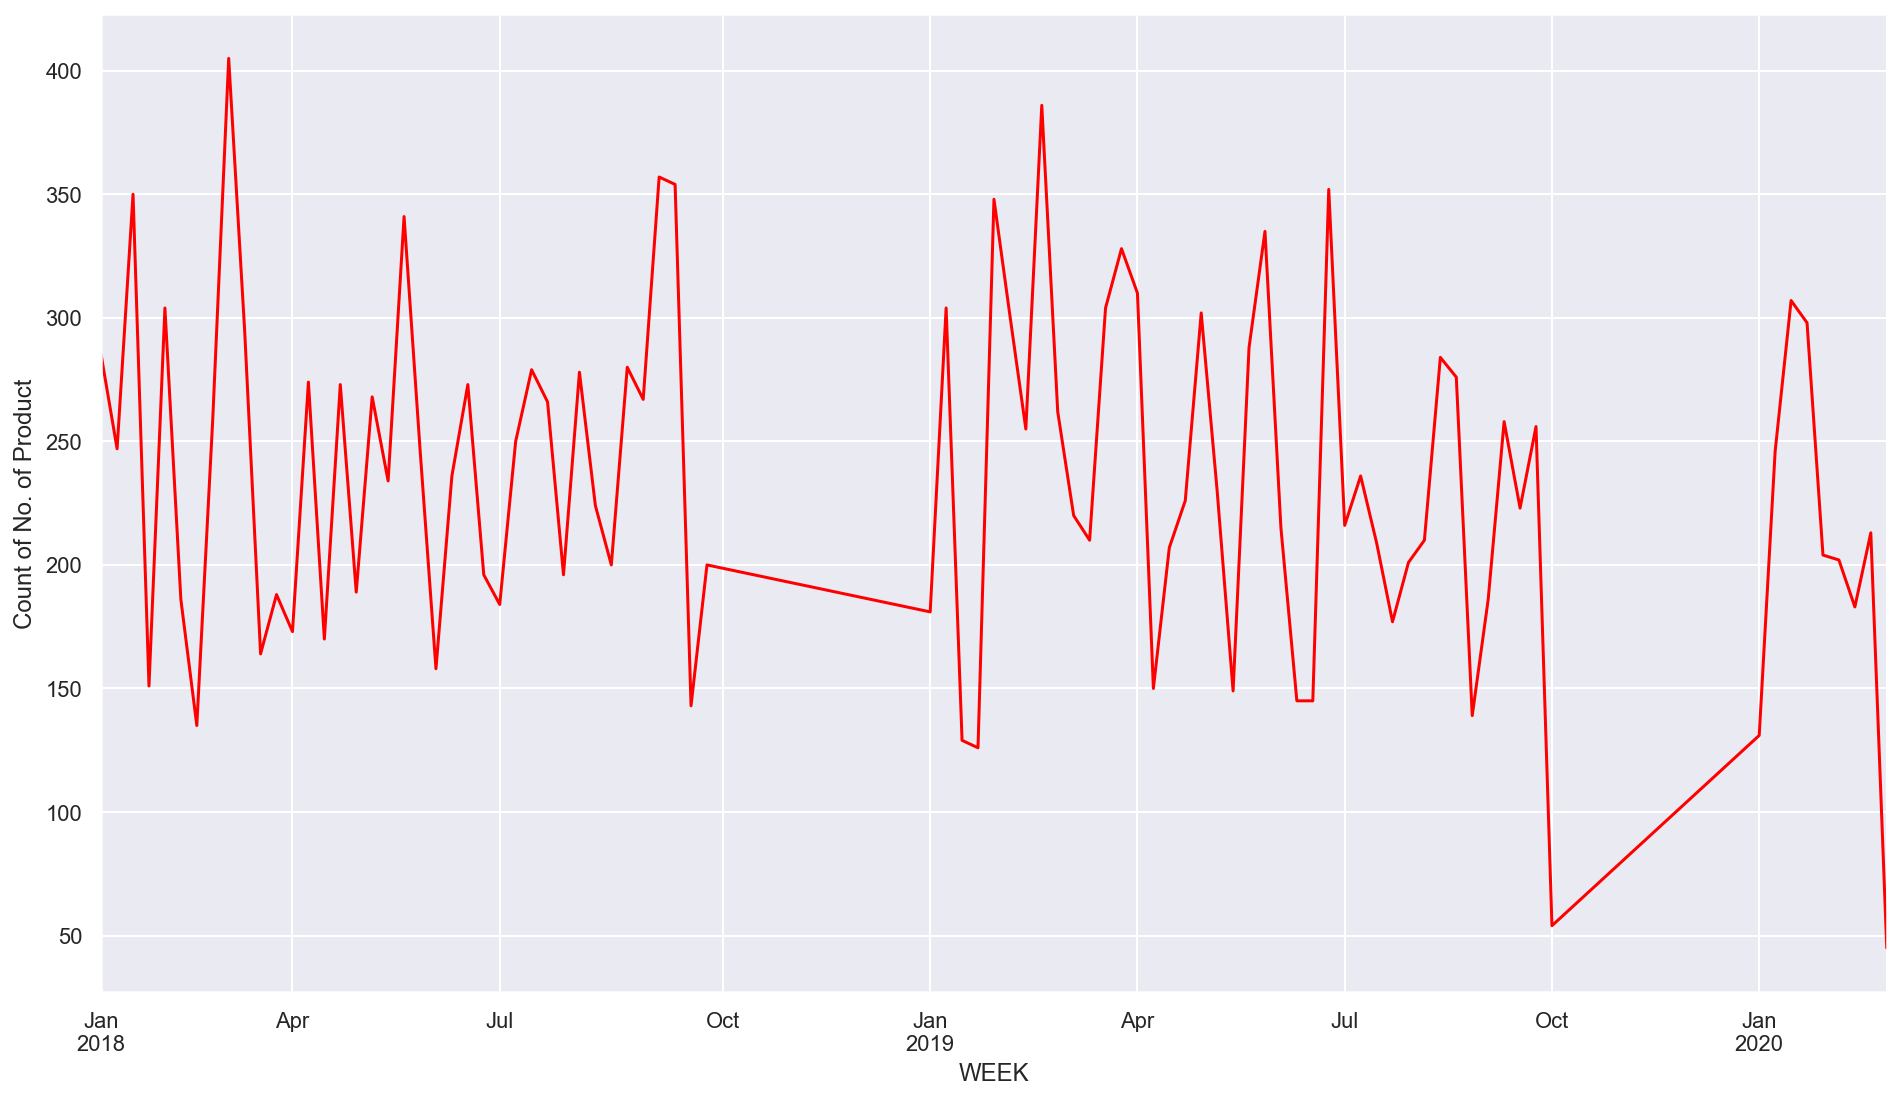

In [26]:
df_week['Num_of_Products'].plot(color='red');
plt.ylabel('Count of No. of Product');
plt.title('WEEKLY PRODUCTS SOLD', fontsize=17)
plt.savefig('ts_week_product.jpg', bbox_inches='tight');

In [27]:
df['Product'].value_counts()


poultry                         640
soda                            597
cereals                         591
ice cream                       579
cheeses                         578
waffles                         575
soap                            574
bagels                          573
lunch meat                      573
juice                           570
eggs                            570
toilet paper                    569
dinner rolls                    567
aluminum foil                   566
coffee/tea                      565
shampoo                         562
beef                            561
paper towels                    556
milk                            555
butter                          555
flour                           555
mixes                           554
all- purpose                    551
dishwashing liquid/detergent    551
ketchup                         548
yogurt                          545
individual meals                544
tortillas                   

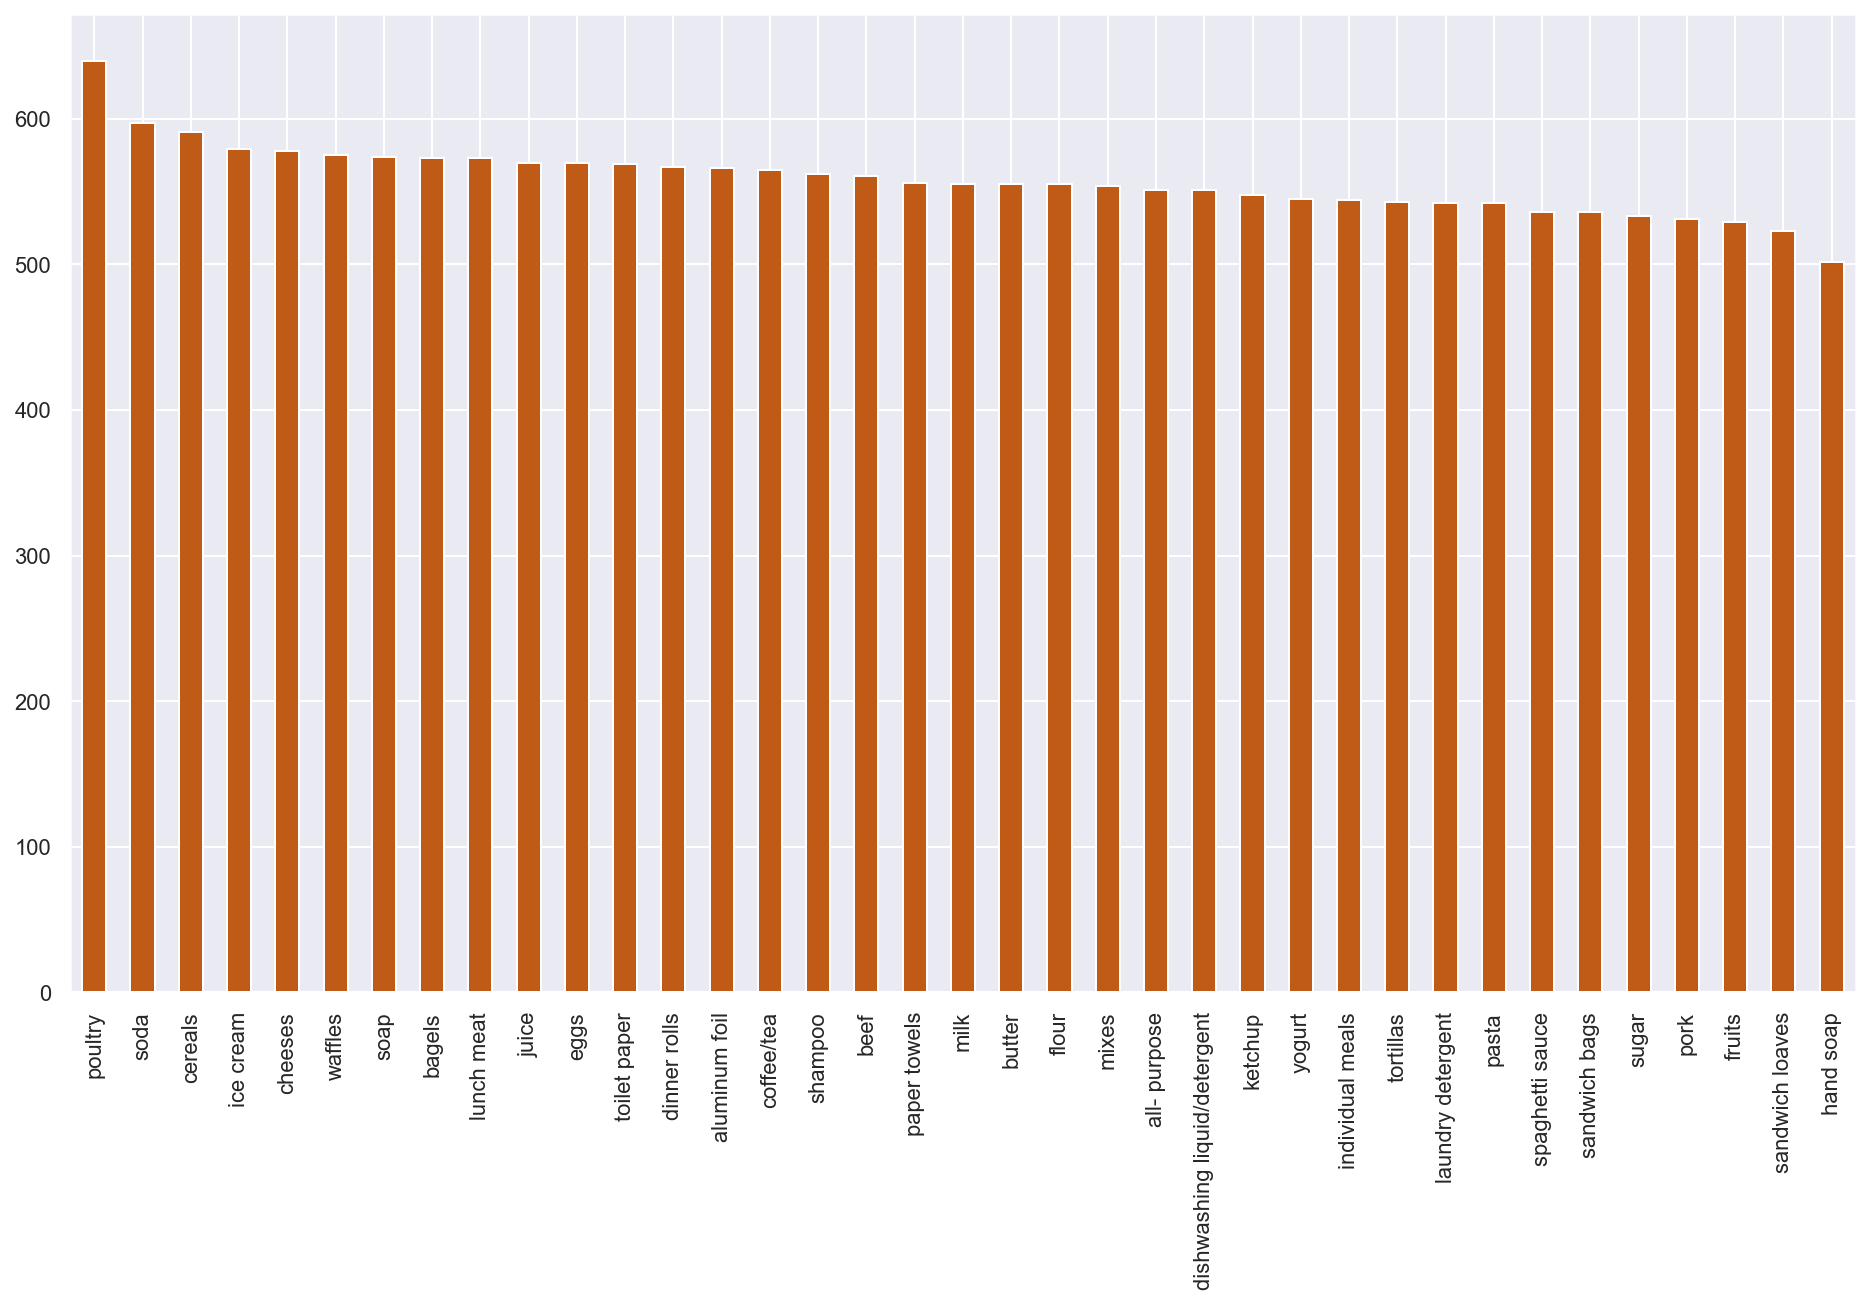

In [28]:
df['Product'].value_counts().plot(kind='bar');
plt.savefig('prod_bar.jpg', bbox_inches='tight');

In [29]:
df3 = df_datesplit.copy()
df_day = pd.DataFrame(df3[['DAY', 'Order_id', 'Product']].groupby('DAY').agg({'Order_id': 'nunique',
                                                                  'Product': 'count'}))
newname = {'Order_id': 'Num_of_Orders', 'Product': 'Num_of_Products'}
df_day.rename(columns=newname, inplace=True)
df_day

,Num_of_Orders,Num_of_Products
DAY,,
Friday,167,3044
Monday,143,2600
Saturday,169,2988
Sunday,169,3109
Thursday,167,2969
Tuesday,157,2943
Wednesday,167,2988


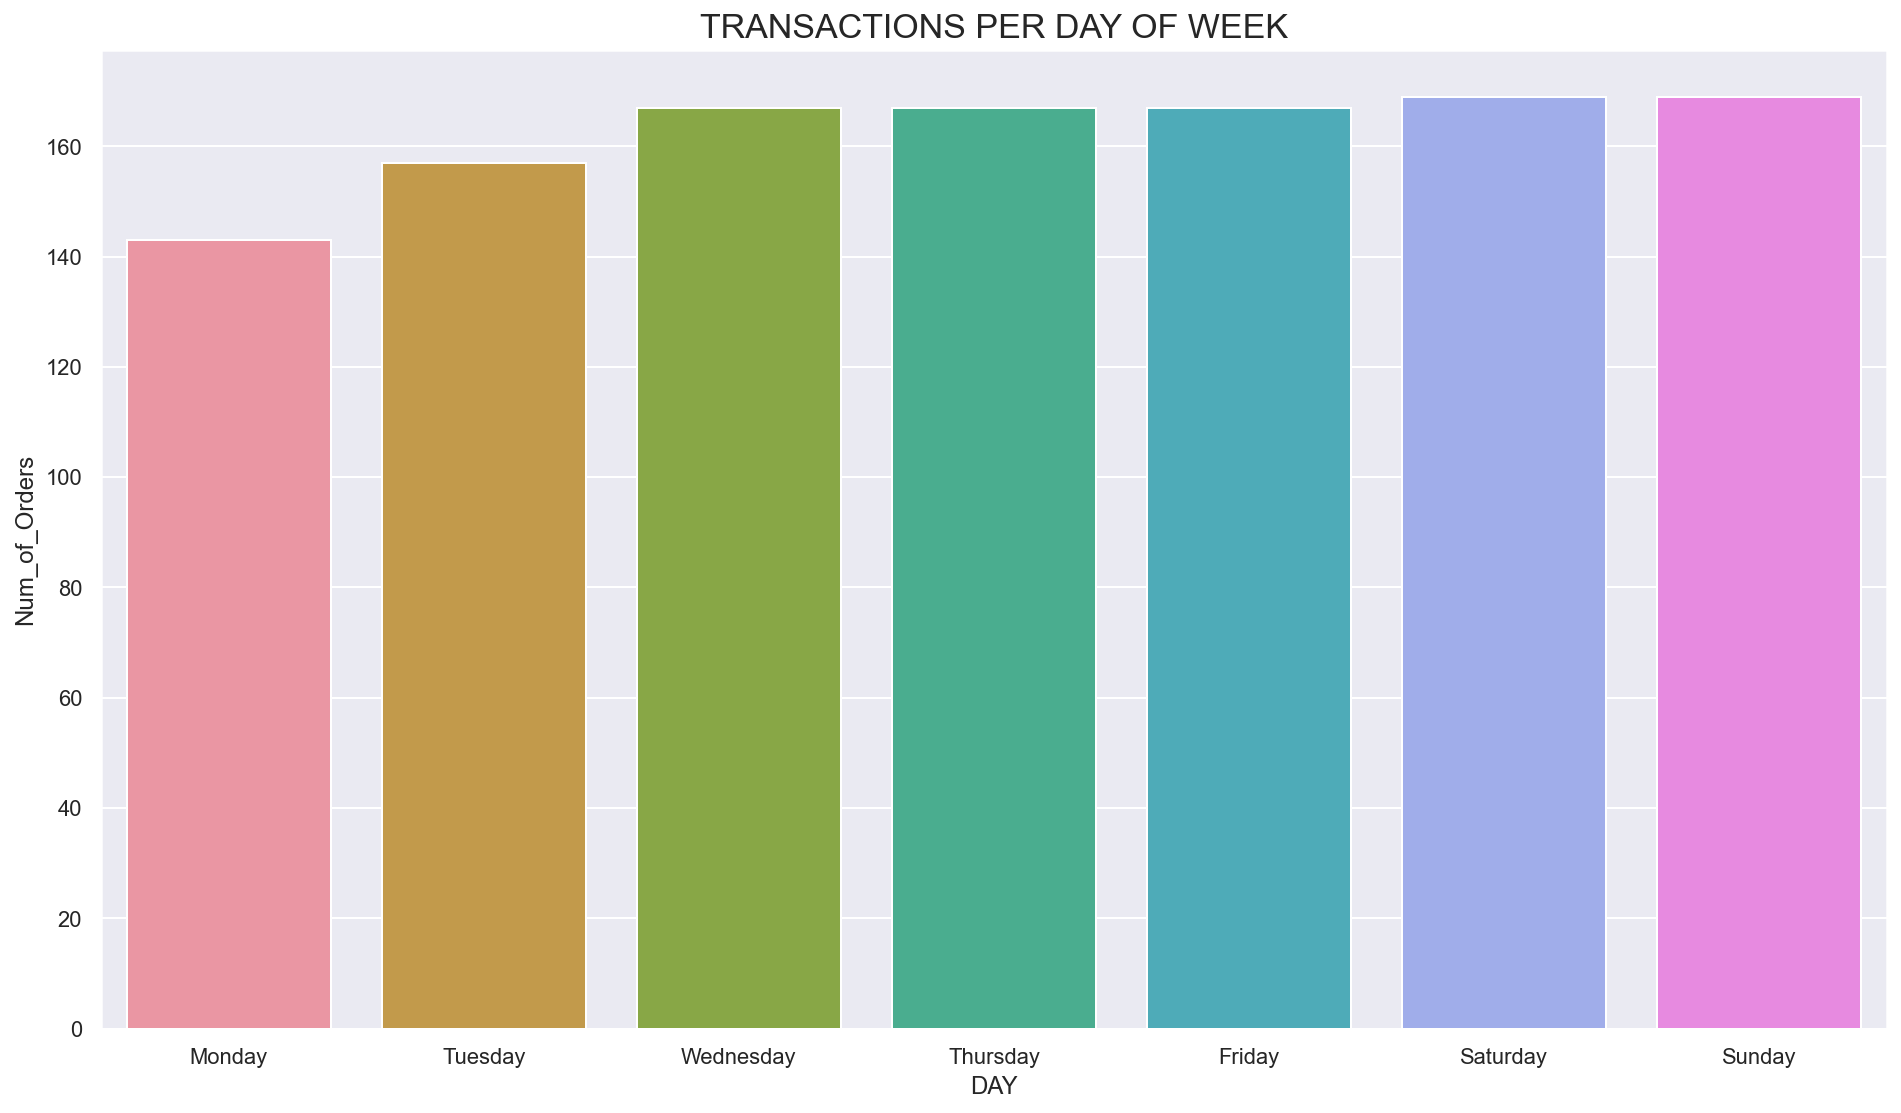

In [60]:
sns.barplot(x=df_day.index.sort_values(ascending=True), y=df_day['Num_of_Orders'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.title('TRANSACTIONS PER DAY OF WEEK', fontsize=17);
plt.savefig('week_bar.jpg', bbox_inches='tight');

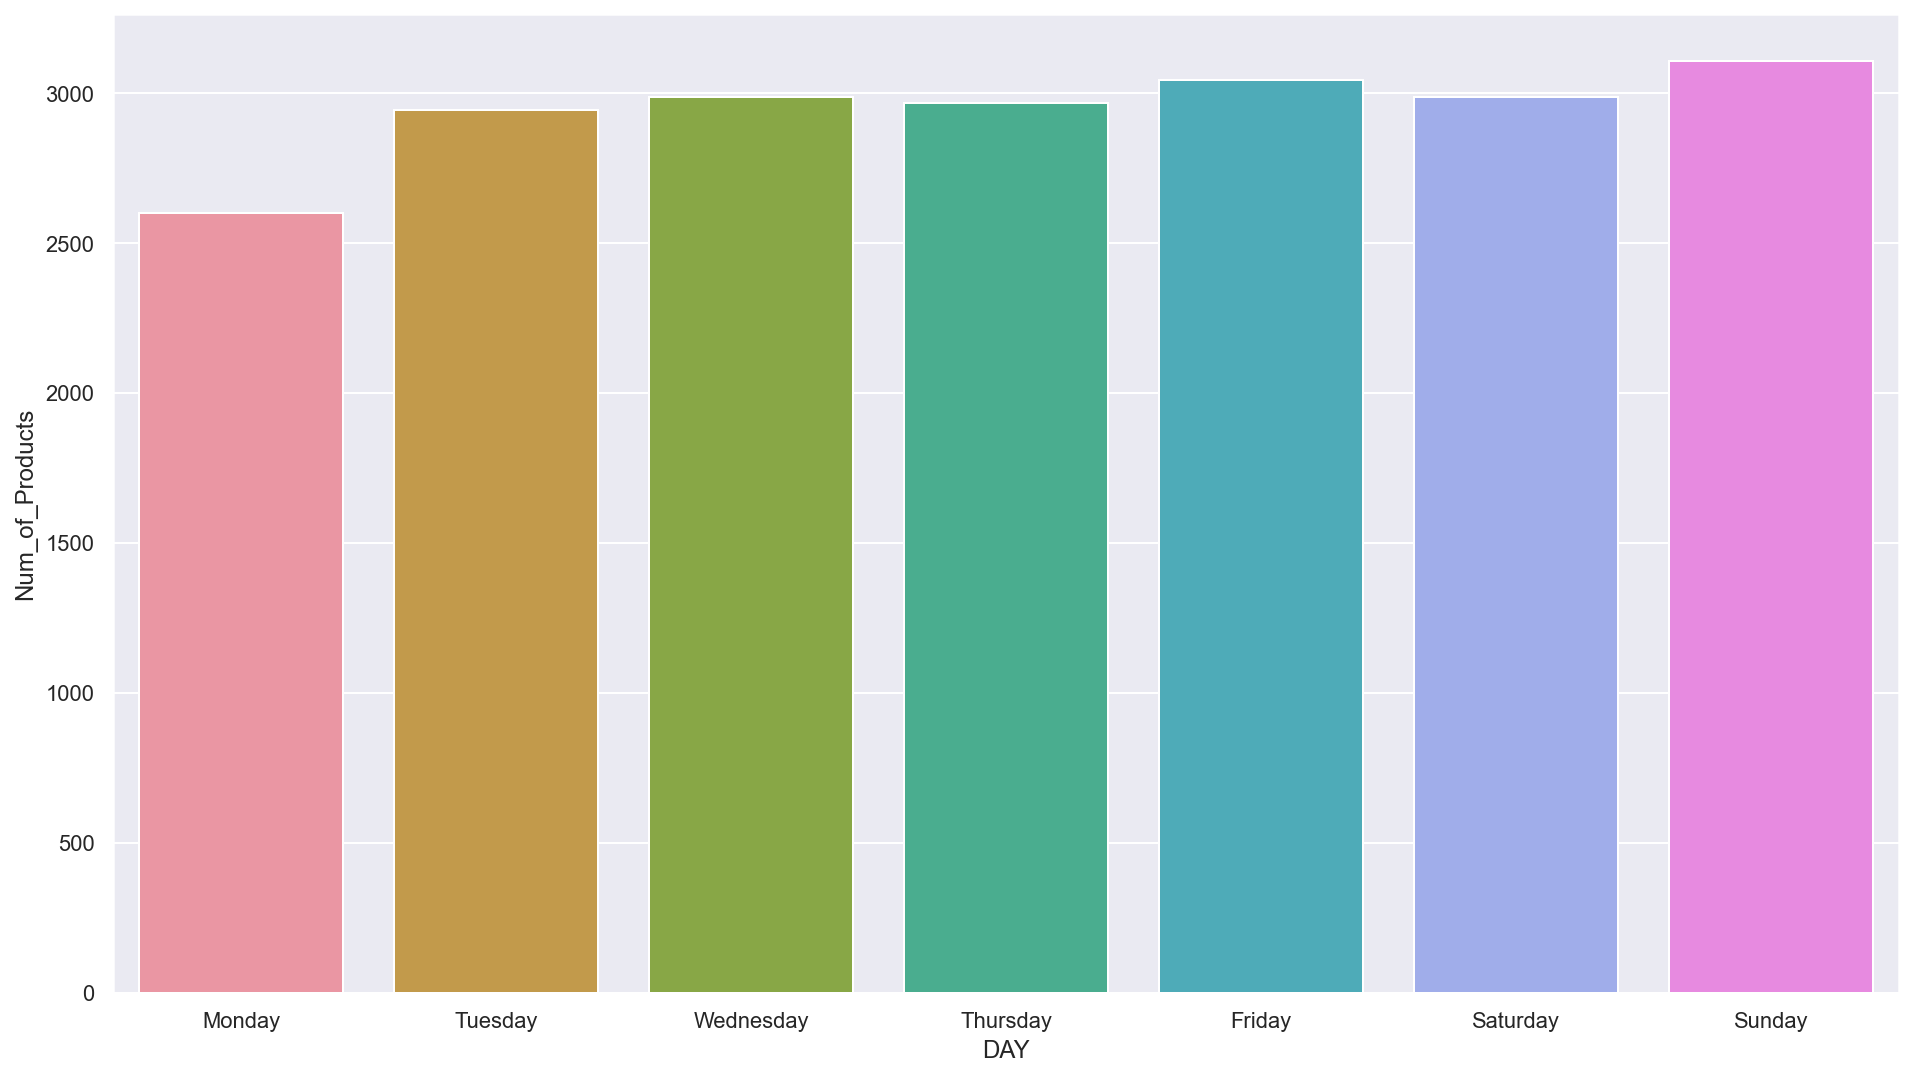

In [31]:
sns.barplot(x=df_day.index.sort_values(ascending=True), y=df_day['Num_of_Products'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

In [32]:
df3 = df_datesplit.copy()
df_monthname = pd.DataFrame(df3[['MONTH_NAME', 'Order_id', 'Product']].groupby('MONTH_NAME').agg({'Order_id': 'nunique',
                                                                  'Product': 'count'}))
newname = {'Order_id': 'Num_of_Orders', 'Product': 'Num_of_Products'}
df_monthname.rename(columns=newname, inplace=True)
df_monthname

,Num_of_Orders,Num_of_Products
MONTH_NAME,,
Apr,110,1937
Aug,107,2120
Feb,156,2815
Jan,174,3227
Jul,115,1997
Jun,105,1827
Mar,124,2255
May,133,2337
Sep,115,2126


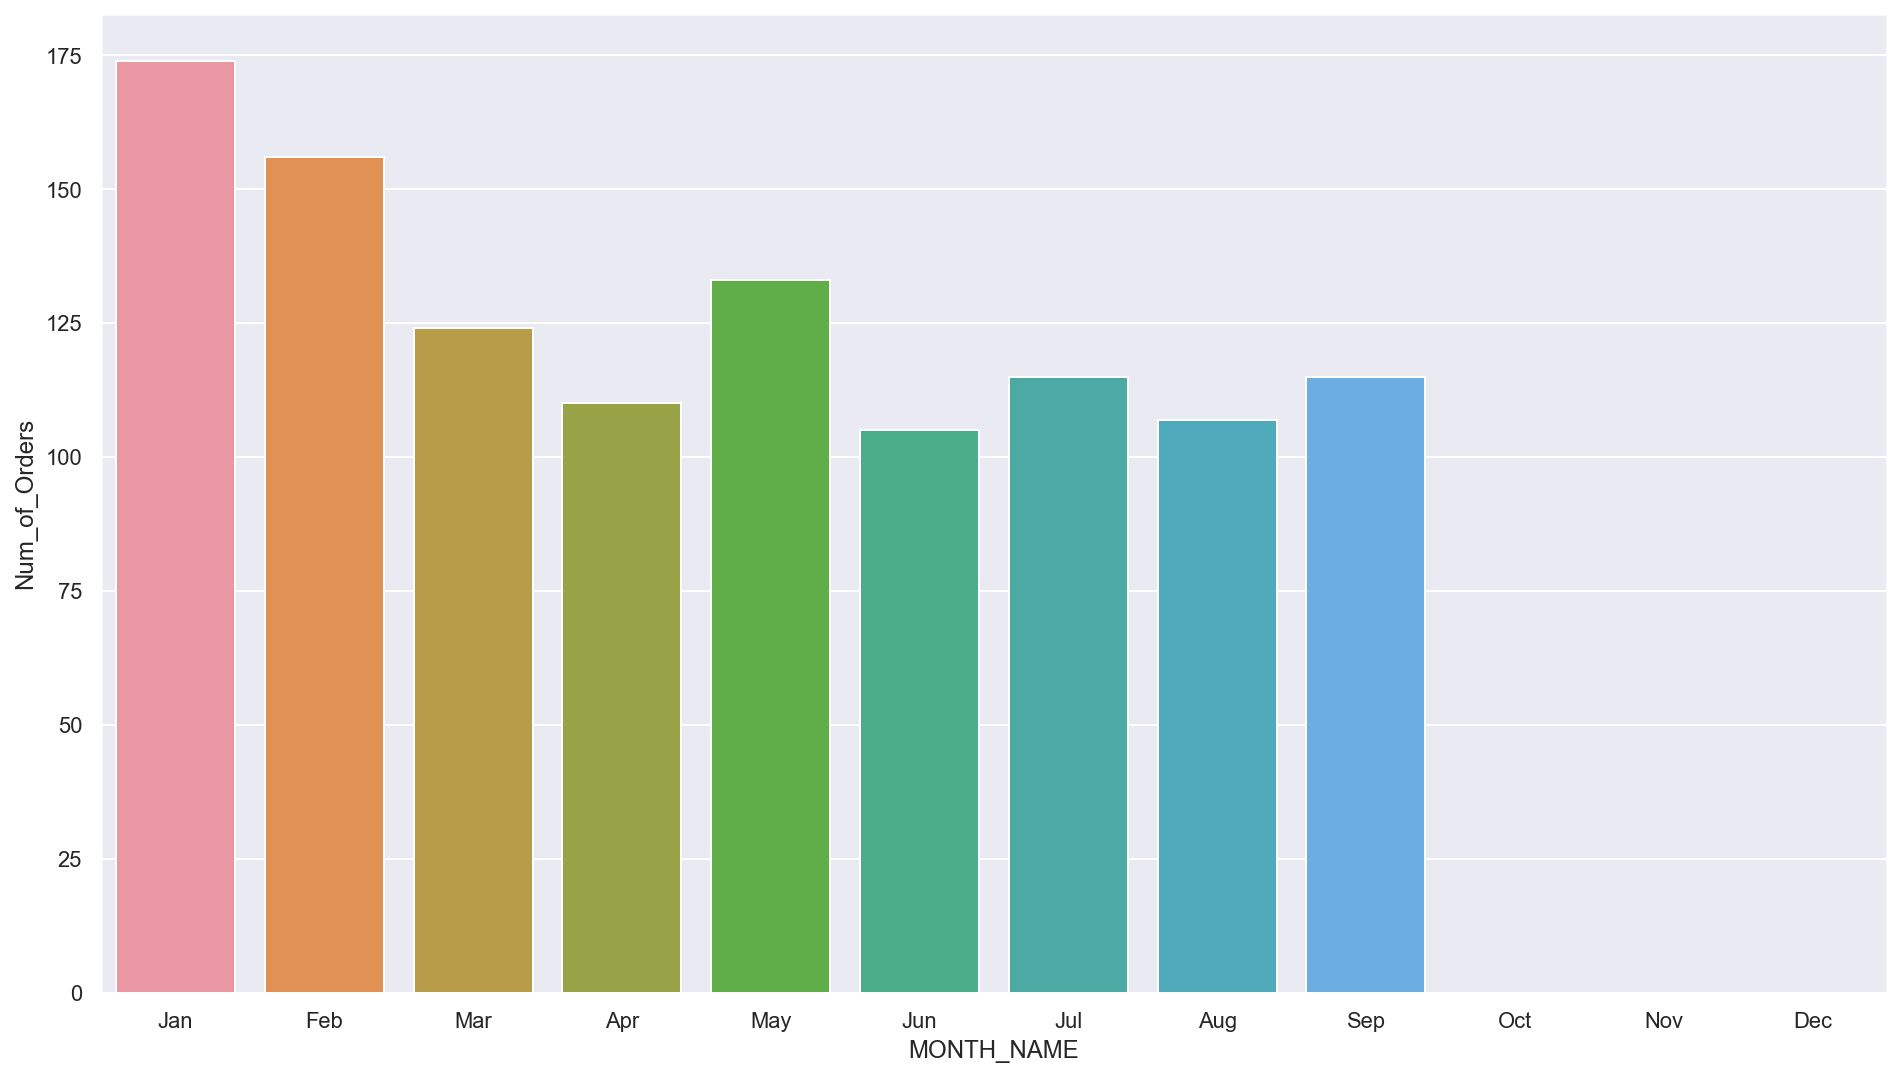

In [33]:
sns.barplot(x=df_monthname.index, y=df_monthname['Num_of_Orders'], order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig('monthwise_orders.jpg', bbox_inches='tight');

In [41]:
df.head()

,Date,Order_id,Product
0,01-01-2018,1,yogurt
1,01-01-2018,1,pork
2,01-01-2018,1,sandwich bags
3,01-01-2018,1,lunch meat
4,01-01-2018,1,all- purpose


In [46]:
df_grpbydate = pd.DataFrame(df.groupby('Date').agg({'Order_id': 'nunique', 'Product': 'count'}))
df_grpbydate.head()
print('Total Num of Orders (Invoices) =', sum(df_grpbydate['Order_id']))
print('Total Num of Products  =', sum(df_grpbydate['Product']))

,Order_id,Product
Date,,
01-01-2018,2,39
01-01-2019,3,68
01-01-2020,2,36
01-02-2018,1,15
01-02-2019,4,114


Total Num of Orders (Invoices) = 1139
Total Num of Products  = 20641
